In [42]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .config("spark.driver.memory", "16g")\
    .getOrCreate()

spark

In [43]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.sql.window import Window
from pyspark.sql.functions import col, lit

from common import *

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_colwidth', None)

plt.rc('axes', labelsize=18, titlesize=18)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=15)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
def get_index(prefix):
    client_sdf = spark.read.csv(f"{prefix}/*/client/0/metadata.csv", header=True)\
        .withColumn(
            "prefix",
            ancestor_udf(F.input_file_name(), lit(3))
        )

    server_sdf = spark.read.csv(f"{prefix}/*/server/0-0/metadata.csv", header=True)\
        .withColumn(
            "prefix",
            ancestor_udf(F.input_file_name(), lit(3))
        )

    return server_sdf.join(client_sdf, on='prefix')\
        .withColumn("duration", col("duration").cast(T.IntegerType()))\
        .withColumn("txns", col("txns").cast(T.IntegerType()))\
        .withColumn("clients", col("clients").cast(T.IntegerType()))\
        .withColumn("rate", col("rate").cast(T.IntegerType()))\
        .withColumn("jitter", F.regexp_extract("prefix", r"jitter(\d+)", 1))

In [49]:
PREFIX = "main/ycsb-jitter"

IGNORE_CACHE = False

index_df = from_cache_or_compute(
    f'{PREFIX}/index.parquet',
    lambda: get_index(PREFIX)\
        .withColumn("config_name", F.regexp_replace("config_name", "\.conf", ""))\
        .toPandas()\
        .convert_dtypes()\
        .astype({
            "wl:hot": "int32",
            "wl:mh": "int32",
            "wl:mp": "int32",
        }),
    ignore_cache=IGNORE_CACHE,
)

index_df

,prefix,version,config_name,duration,txns,clients,rate,sample,wl:name,wl:mh,...,wl:mh_zipf,wl:mp_parts,wl:hot,wl:value_size,wl:mh_homes,wl:writes,wl:nearest,wl:sp_partition,wl:sh_home,jitter
0,file:///home/ctring/data/detock/main/ycsb-jitter/ddr_ts-clients3000jitter0,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,0
1,file:///home/ctring/data/detock/main/ycsb-jitter/ddr_ts-clients3000jitter10,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,10
2,file:///home/ctring/data/detock/main/ycsb-jitter/ddr_ts-clients3000jitter15,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,15
3,file:///home/ctring/data/detock/main/ycsb-jitter/ddr_ts-clients3000jitter20,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,20
4,file:///home/ctring/data/detock/main/ycsb-jitter/ddr_ts-clients3000jitter25,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,25
5,file:///home/ctring/data/detock/main/ycsb-jitter/ddr_ts-clients3000jitter30,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,30
6,file:///home/ctring/data/detock/main/ycsb-jitter/ddr_ts-clients3000jitter35,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,35
7,file:///home/ctring/data/detock/main/ycsb-jitter/ddr_ts-clients3000jitter40,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,40
8,file:///home/ctring/data/detock/main/ycsb-jitter/ddr_ts-clients3000jitter5,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,5
9,file:///home/ctring/data/detock/main/ycsb-jitter/ddr_ts-clients200jitter0,1.0.1022,ddr_ts,15,2000000,200,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,0


In [54]:
PREFIX_OVERSHOOT10 = "main/ycsb-jitter-overshoot10"

IGNORE_CACHE = False

index_overshoot10_df = from_cache_or_compute(
    f'{PREFIX_OVERSHOOT10}/index.parquet',
    lambda: get_index(PREFIX_OVERSHOOT10)\
        .withColumn("config_name", F.regexp_replace("config_name", "\.conf", ""))\
        .toPandas()\
        .convert_dtypes()\
        .astype({
            "wl:hot": "int32",
            "wl:mh": "int32",
            "wl:mp": "int32",
        }),
    ignore_cache=IGNORE_CACHE,
)

index_overshoot10_df

Saved to: main/ycsb-jitter-overshoot10/index.parquet


,prefix,version,config_name,duration,txns,clients,rate,sample,wl:name,wl:mh,...,wl:mh_zipf,wl:mp_parts,wl:hot,wl:value_size,wl:mh_homes,wl:writes,wl:nearest,wl:sp_partition,wl:sh_home,jitter
0,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients3000jitter0,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,0
1,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients3000jitter10,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,10
2,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients3000jitter15,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,15
3,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients3000jitter20,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,20
4,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients3000jitter25,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,25
5,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients3000jitter30,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,30
6,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients3000jitter35,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,35
7,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients3000jitter40,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,40
8,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients3000jitter5,1.0.1022,ddr_ts,30,2000000,3000,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,5
9,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients200jitter0,1.0.1022,ddr_ts,15,2000000,200,0,10,basic,10,...,1,2,100,50,2,10,1,-1,-1,0


# Throughput

In [52]:
IGNORE_CACHE = False

def compute_throughput(prefix):
    res = throughput(
        spark,
        prefix,
        start_offset_sec=5,
        duration_sec=50
    ).first().throughput
    print(prefix, res)
    return res

    
def compute_all_throughputs(index_sdf):
    # Extract all prefixes in the index
    throughput_df = index_sdf.select("prefix").toPandas()
    # Compute the throughput of each prefix
    throughput_df["throughput"] = throughput_df.apply(lambda r : compute_throughput(r["prefix"]), axis=1)
    # Associate metadata from the index to the throughputs
    return throughput_df.merge(index_sdf.toPandas(), on="prefix")


throughput_df = from_cache_or_compute(
    f'{PREFIX}/throughput.parquet',
    lambda: compute_all_throughputs(get_index(PREFIX).where(col("clients") == 3000))\
        .sort_values("jitter", key=lambda k: k.astype("int")),
    ignore_cache=IGNORE_CACHE,
)

throughput_overshoot10_df = from_cache_or_compute(
    f'{PREFIX_OVERSHOOT10}/throughput.parquet',
    lambda: compute_all_throughputs(get_index(PREFIX_OVERSHOOT10).where(col("clients") == 3000))\
        .sort_values("jitter", key=lambda k: k.astype("int")),
    ignore_cache=IGNORE_CACHE,
)

# Deadlocks

In [53]:
def get_deadlocks(thrp_df):
    deadlocks_df = thrp_df[["prefix", "jitter"]].copy()
    deadlocks_df["deadlock_cnt"] = 0
    deadlocks_df["deadlock_sz"] = 0

    for i, row in deadlocks_df.iterrows():
        sdf = deadlocks_csv(spark, row.prefix).where(col("replica") == 0)
        deadlocks_df.at[i, "deadlock_cnt"] = sdf.count()
        deadlocks_df.at[i, "deadlock_sz"] = sdf.agg({"vertices": "sum"}).collect()[0][0]

    return deadlocks_df

Saved to: main/ycsb-jitter/deadlocks.parquet


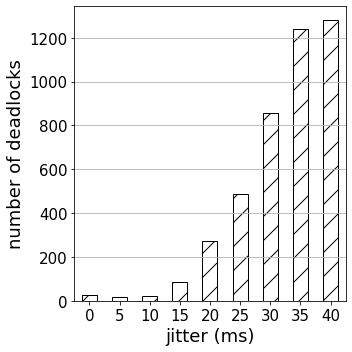

In [40]:
IGNORE_CACHE = False

deadlocks_df = from_cache_or_compute(
    f'{PREFIX}/deadlocks.parquet',
    lambda: get_deadlocks(throughput_df),
    ignore_cache=IGNORE_CACHE,
)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
deadlocks_df.plot.bar(x="jitter", y="deadlock_cnt", rot=0, ax=ax, legend=False, fill=False, hatch='/')
ax.set_xlabel("jitter (ms)")
ax.set_ylabel("number of deadlocks")
ax.grid(axis='y')
fig.tight_layout()
fig.savefig('output/jitter-deadlocks.pdf')
# fig.savefig('output/jitter-deadlocks.pdf')
# deadlocks_df.plot.bar(x="jitter", y="deadlock_sz", rot=0)

Saved to: main/ycsb-jitter-overshoot10/deadlocks.parquet


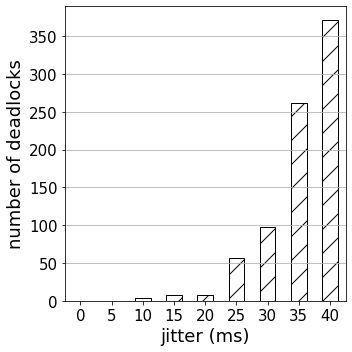

In [41]:
IGNORE_CACHE=False

deadlocks_overshoot10_df = from_cache_or_compute(
    f'{PREFIX_OVERSHOOT10}/deadlocks.parquet',
    lambda: get_deadlocks(throughput_overshoot10_df),
    ignore_cache=IGNORE_CACHE,
)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
deadlocks_overshoot10_df.plot.bar(x="jitter", y="deadlock_cnt", rot=0, ax=ax, legend=False, fill=False, hatch='/')
ax.set_xlabel("jitter (ms)")
ax.set_ylabel("number of deadlocks")
ax.grid(axis='y')
fig.tight_layout()
fig.savefig('output/jitter-deadlocks-overshoot10.pdf')

# Latency

In [24]:
prefixes = list(
    map(
        lambda r : r["prefix"],
        index_sdf.select("prefix").where(col("clients") == 200).collect()
    )
)
latency_sdf = latency(spark, prefixes).cache()

percentile_cols = [
    F.percentile_approx("latency", 0.5).alias("p50"),
    F.percentile_approx("latency", 0.90).alias("p90"),
    F.percentile_approx("latency", 0.95).alias("p95"),
    F.percentile_approx("latency", 0.99).alias("p99"),
]

latency_sdf = latency_sdf.groupBy("prefix").agg(*percentile_cols).cache()

In [33]:
prefixes = list(
    map(
        lambda r : r["prefix"],
        index_overshoot10_sdf.select("prefix").where(col("clients") == 200).collect()
    )
)
latency_overshoot10_sdf = latency(spark, prefixes).cache()

percentile_cols = [
    F.percentile_approx("latency", 0.5).alias("p50"),
    F.percentile_approx("latency", 0.90).alias("p90"),
    F.percentile_approx("latency", 0.95).alias("p95"),
    F.percentile_approx("latency", 0.99).alias("p99"),
]

latency_overshoot10_sdf = latency_overshoot10_sdf.groupBy("prefix").agg(*percentile_cols).cache()

In [25]:
IGNORE_CACHE = False

latency_df = from_cache_or_compute(
    f'{PREFIX}/latency.parquet',
    lambda: latency_sdf.toPandas().merge(index_df, on="prefix")\
        .sort_values("jitter", key=lambda k: k.astype('int')),
    ignore_cache=IGNORE_CACHE,
)
latency_df

Saved to: main/ycsb-jitter/latency.parquet


,prefix,p50,p90,p95,p99,version,config_name,duration,txns,clients,...,wl:mh_zipf,wl:mp_parts,wl:hot,wl:value_size,wl:mh_homes,wl:writes,wl:nearest,wl:sp_partition,wl:sh_home,jitter
5,file:///home/ctring/data/detock/main/ycsb-jitter/ddr_ts-clients200jitter0,88.214016,128.354816,150.649344,227.846912,1.0.1022,ddr_ts,15,2000000,200,...,1,2,100,50,2,10,1,-1,-1,0
0,file:///home/ctring/data/detock/main/ycsb-jitter/ddr_ts-clients200jitter5,88.736512,127.912448,143.966720,222.220288,1.0.1022,ddr_ts,15,2000000,200,...,1,2,100,50,2,10,1,-1,-1,5
8,file:///home/ctring/data/detock/main/ycsb-jitter/ddr_ts-clients200jitter10,89.676544,126.364160,143.480832,224.847616,1.0.1022,ddr_ts,15,2000000,200,...,1,2,100,50,2,10,1,-1,-1,10
4,file:///home/ctring/data/detock/main/ycsb-jitter/ddr_ts-clients200jitter15,91.115520,129.817856,146.696448,224.949760,1.0.1022,ddr_ts,15,2000000,200,...,1,2,100,50,2,10,1,-1,-1,15
3,file:///home/ctring/data/detock/main/ycsb-jitter/ddr_ts-clients200jitter20,92.935168,132.967168,152.972800,229.396992,1.0.1022,ddr_ts,15,2000000,200,...,1,2,100,50,2,10,1,-1,-1,20
2,file:///home/ctring/data/detock/main/ycsb-jitter/ddr_ts-clients200jitter25,94.471936,135.543552,152.739328,228.898048,1.0.1022,ddr_ts,15,2000000,200,...,1,2,100,50,2,10,1,-1,-1,25
7,file:///home/ctring/data/detock/main/ycsb-jitter/ddr_ts-clients200jitter30,96.168448,134.613248,151.763968,230.586112,1.0.1022,ddr_ts,15,2000000,200,...,1,2,100,50,2,10,1,-1,-1,30
1,file:///home/ctring/data/detock/main/ycsb-jitter/ddr_ts-clients200jitter35,98.243840,139.802624,158.958080,233.632256,1.0.1022,ddr_ts,15,2000000,200,...,1,2,100,50,2,10,1,-1,-1,35
6,file:///home/ctring/data/detock/main/ycsb-jitter/ddr_ts-clients200jitter40,100.425216,143.306496,164.840192,245.550080,1.0.1022,ddr_ts,15,2000000,200,...,1,2,100,50,2,10,1,-1,-1,40


In [34]:
IGNORE_CACHE = False

latency_overshoot10_df = from_cache_or_compute(
    f'{PREFIX_OVERSHOOT10}/latency.parquet',
    lambda: latency_overshoot10_sdf.toPandas().merge(index_overshoot10_df, on="prefix")\
        .sort_values("jitter", key=lambda k: k.astype('int')),
    ignore_cache=IGNORE_CACHE,
)
latency_overshoot10_df

,prefix,p50,p90,p95,p99,version,config_name,duration,txns,clients,...,wl:mh_zipf,wl:mp_parts,wl:hot,wl:value_size,wl:mh_homes,wl:writes,wl:nearest,wl:sp_partition,wl:sh_home,jitter
4,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients200jitter0,87.683328,129.467136,150.941952,223.047424,1.0.1022,ddr_ts,15,2000000,200,...,1,2,100,50,2,10,1,-1,-1,0
7,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients200jitter5,87.965440,126.273536,143.275008,219.596288,1.0.1022,ddr_ts,15,2000000,200,...,1,2,100,50,2,10,1,-1,-1,5
0,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients200jitter10,88.903680,125.700608,142.507776,218.854912,1.0.1022,ddr_ts,15,2000000,200,...,1,2,100,50,2,10,1,-1,-1,10
8,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients200jitter15,90.123776,128.137984,145.411584,219.565312,1.0.1022,ddr_ts,15,2000000,200,...,1,2,100,50,2,10,1,-1,-1,15
2,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients200jitter20,91.071232,129.483776,147.523840,220.957184,1.0.1022,ddr_ts,15,2000000,200,...,1,2,100,50,2,10,1,-1,-1,20
6,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients200jitter25,93.030144,131.833600,149.712128,223.096576,1.0.1022,ddr_ts,15,2000000,200,...,1,2,100,50,2,10,1,-1,-1,25
3,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients200jitter30,94.932736,133.360896,151.834880,225.751552,1.0.1022,ddr_ts,15,2000000,200,...,1,2,100,50,2,10,1,-1,-1,30
5,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients200jitter35,95.788032,136.423168,157.627392,230.614528,1.0.1022,ddr_ts,15,2000000,200,...,1,2,100,50,2,10,1,-1,-1,35
1,file:///home/ctring/data/detock/main/ycsb-jitter-overshoot10/ddr_ts-clients200jitter40,97.392128,142.736384,173.914112,238.009856,1.0.1022,ddr_ts,15,2000000,200,...,1,2,100,50,2,10,1,-1,-1,40


# Plot

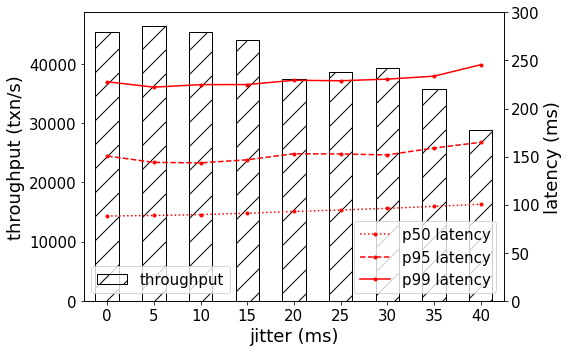

In [27]:
_, ax = plt.subplots(1, 1, figsize=(8, 5))

throughput_df.plot.bar(ax=ax, x="jitter", y="throughput", rot=0, fill=False, hatch='/')
ax.set_ylabel("throughput (txn/s)")
ax.set_xlabel("jitter (ms)")
ax.legend(loc="lower left")
ax2 = ax.twinx()

latency_df.plot(ax=ax2, x="jitter", y="p50", label='p50 latency', linestyle='dotted', marker='.', color="red")
latency_df.plot(ax=ax2, x="jitter", y="p95", label='p95 latency', linestyle='dashed', marker='.', color="red")
latency_df.plot(ax=ax2, x="jitter", y="p99", label='p99 latency', marker='.', color="red")
ax2.set_ylabel("latency (ms)")
ax2.set_ylabel("latency (ms)")
ax2.set_ylim((0, 300))

ax2.legend(loc="lower right", ncol=1)
 
plt.tight_layout()
plt.savefig("output/jitter.pdf")

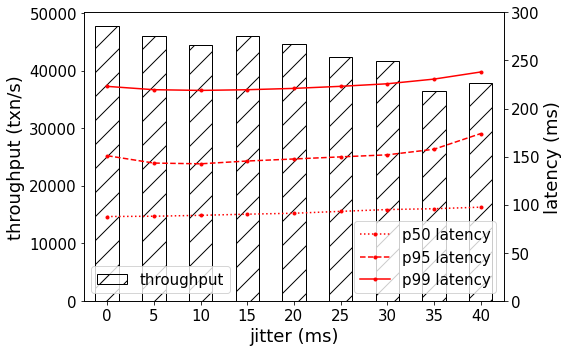

In [32]:
_, ax = plt.subplots(1, 1, figsize=(8, 5))

throughput_overshoot10_df.plot.bar(ax=ax, x="jitter", y="throughput", rot=0, fill=False, hatch='/')
ax.set_ylabel("throughput (txn/s)")
ax.set_xlabel("jitter (ms)")
ax.legend(loc="lower left")
ax2 = ax.twinx()

latency_overshoot10_df.plot(ax=ax2, x="jitter", y="p50", label='p50 latency', linestyle='dotted', marker='.', color="red")
latency_overshoot10_df.plot(ax=ax2, x="jitter", y="p95", label='p95 latency', linestyle='dashed', marker='.', color="red")
latency_overshoot10_df.plot(ax=ax2, x="jitter", y="p99", label='p99 latency', marker='.', color="red")
ax2.set_ylabel("latency (ms)")
ax2.set_ylabel("latency (ms)")
ax2.set_ylim((0, 300))

ax2.legend(loc="lower right", ncol=1)
 
plt.tight_layout()
plt.savefig("output/jitter-overshoot10.pdf")